In [1]:
# Dependencies
from modules.dataset.entities import Entities
from modules.dataset.tweets import Tweets
from langdetect import detect
import matplotlib.pyplot as plt
import pandas as pd
import json
import re

%matplotlib inline

In [2]:
# Paths
#TWEETS_RAW_PATH = 'data/tweets.jsonl'
TWEETS_DB_PATH = 'data/database/tweets.csv'
HASHTAGS_DB_PATH = 'data/database/entities.csv'
WORDS_DB_PATH = 'data/database/words.csv'
SUBS_HASHTAGS_PATH = 'data/hashtag_subs.json'
SUBS_CONTRACT_PATH = 'data/contract_forms.json'

In [3]:
# Set network years
YEARS = [2017, 2018]

# Dataset creation

Once words and hashtags are extracted, they are stored in Pandas DataFrames with the following attributes:

1. <code> tweet_id </code> : Reference to the tweet ID
2. <code> entity_index </code> : Position of the word in the sentence (tweet) - useful to delete self loops 
3. <code> entity_text </code> : Text
4. <code> entity_tag </code> : Part Of Speech tag 
			

In [8]:
# Load Tweets dataset

# Initialize Tweets class
tweets = Tweets()
    
# Load tweets from disk
tweets = Tweets()
tweets.df = pd.read_csv(TWEETS_DB_PATH)[['created_at','id_str','text']]
tweets.df = tweets.df.rename(columns={'created_at':'tweet_date','id_str':'tweet_id','text':'tweet_text'})
print('BEFORE: ',tweets.df.shape)
is_english = tweets.df.tweet_text.apply(lambda x: detect(x) == 'en')
# Filter out dataset language
tweets.df = tweets.df[is_english].drop_duplicates()
print('AFTER: ',tweets.df.shape)
tweets.to_json('data/database/tweets.json')
tweets.to_csv('data/database/tweets_en.csv')
tweets.df.head()

BEFORE:  (3026, 3)
AFTER:  (2981, 3)


,tweet_date,tweet_id,tweet_text
0,Sat Jun 30 22:35:06 +0000 2018,1013189209488797697,"#PrideMonth may be ending today, but we will c..."
1,Sat Jun 30 19:35:07 +0000 2018,1013143915308953606,“This disaster leaves us in extreme poverty......
2,Sat Jun 30 18:35:07 +0000 2018,1013128815575470081,We want more women on ballots 🗳️ when we go ou...
3,Sat Jun 30 16:35:09 +0000 2018,1013098625768009728,“The idea that sexism &amp; misogyny in online...
4,Sat Jun 30 15:05:12 +0000 2018,1013075989885341697,"When women are targeted online, the abuse is m..."


In [9]:
# Extract entities (i.e. hashtags and words)

# Load substitutions dictionary
subs = {}
# Load hahstag substitutions
with open(SUBS_HASHTAGS_PATH, 'r') as file:
    subs = {**subs, **json.load(file)}
# Load contact forms substitutions
with open(SUBS_CONTRACT_PATH, 'r') as file:
    subs = {**subs, **json.load(file)}

# Retrieve hastags and words entities tables
hashtags, words = tweets.get_entities(subs=subs)
# Store entities tables to disk
hashtags.to_json(HASHTAGS_DB_PATH[:-3]+'json')
words.to_json(WORDS_DB_PATH[:-3]+'json')

In [10]:
# Show hashtags dataset header
hashtags.df.head()

,tweet_id,entity_index,entity_text,entity_tag,entity_conf
54141,847985662850723840,13,#childmarriage,#,0.3662
54127,848030929482285056,15,#HeForShe,#,0.9254
54089,848121534204039169,14,#stoptherobbery,#,0.9086
54047,848212148480356352,0,#ThanksForTyping,#,0.9217
54037,848257441942962181,10,#WomenofSyria,#,0.7413


In [11]:
hashtags.df.shape

(3139, 5)

In [12]:
hashtags.df.drop_duplicates(inplace=True)

In [13]:
hashtags.df.shape

(3139, 5)

In [14]:
hashtags.to_json(HASHTAGS_DB_PATH[:-3]+'json')

In [15]:
# Show words dataset header
words.df.head()

,tweet_id,entity_index,entity_text,entity_tag,entity_conf
55035,847985662850723840,0,these,D,0.9818
55036,847985662850723840,1,teens,N,0.9962
55037,847985662850723840,2,in,P,0.9973
55038,847985662850723840,3,bangladesh,^,0.9847
55039,847985662850723840,4,are,V,0.9852


In [16]:
words.df.shape

(75154, 5)

In [17]:
words.df.drop_duplicates(inplace=True)

In [18]:
words.df.shape

(75154, 5)

## Words filtering

In [19]:
# Recognize pronouns and clean from symbols
words.clean_entities()

In [20]:
# Automatically and manually found pronouns
words.df[words.df.entity_tag == 'O'].shape[0]

3478

In [21]:
# Manually found pronouns
words.df[(words.df.entity_conf == 1.0) & (words.df.entity_tag == 'O')].shape[0]

3462

In [22]:
# Filter on POS tag
words.df = words.df[words.df.entity_tag.isin(['N', 'V', 'R', 'A', 'O', 'S'])]
words.df.head()

,tweet_id,entity_index,entity_text,entity_tag,entity_conf
55036,847985662850723840,1,teen,N,0.9962
55040,847985662850723840,5,take,V,0.9994
55041,847985662850723840,6,it,O,1.0000
55043,847985662850723840,8,their,O,1.0000
55045,847985662850723840,10,hand,N,0.9960


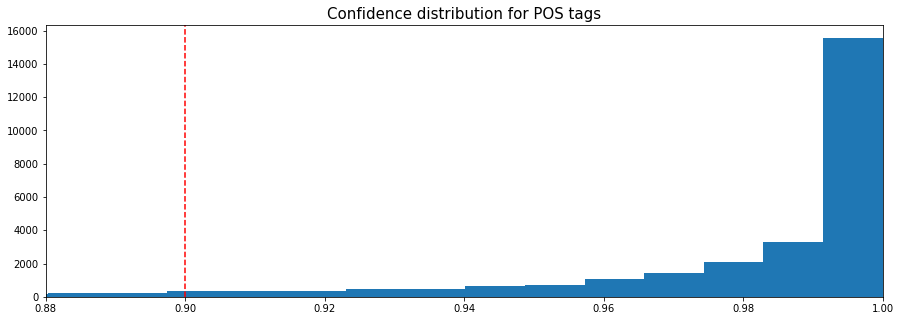

There are 5534 (17.26%) words under 0.90 confidence interval
There will be 26531 (82.74%) words remaining inside 0.90 confidence interval


In [23]:
# Set threshold on confidence
conf = 0.9

# Show confidence distribution
fig, ax = plt.subplots(figsize=(15, 5))
_ = ax.set_title('Confidence distribution for POS tags',fontsize=15)
_ = ax.hist(words.df.entity_conf, bins=100)
_ = ax.set_xlim(left=0.88, right=1.0)
_ = ax.axvline(x=conf, c='r', ls='--')
# _ = plt.savefig('images/preprocessing/tag_conf.png')
_ = plt.show()

# info
print('There are {:d} ({:.02f}%) words under {:.2f} confidence interval'.format(
    sum(words.df.entity_conf < conf), sum(words.df.entity_conf < conf) / words.df.shape[0] * 100, conf
))
# info
print('There will be {:d} ({:.02f}%) words remaining inside {:.2f} confidence interval'.format(
    sum(words.df.entity_conf >= conf), sum(words.df.entity_conf >= conf) / words.df.shape[0] * 100, conf
))

In [24]:
# Filter on confidence
words.df = words.df[words.df.entity_conf >= conf]

In [25]:
# Number of pronouns after cleaning
words.df[words.df.entity_tag == 'O'].shape[0]

3462

In [26]:
# Total number of words extracted 
words.df.shape[0]

26531

In [27]:
words.to_json(WORDS_DB_PATH[:-3]+'json')

## Tweets filtering

In [28]:
# Make a copy of tweets dataset
filtered = Tweets()
filtered.df = tweets.df.copy()

In [29]:
# Filter out \r and \n characters from tweets

# Get tweet text
tweet_text = filtered.df.tweet_text
# Filter out \t, \r and \n characters from tweets
tweet_text = tweet_text.apply(lambda txt: re.sub(r'[\t\n\r]+', ' ', txt))
tweet_text = tweet_text.apply(lambda txt: re.sub(r'[ ]+', ' ', txt))
# Save dataset to disk
filtered.df.tweet_text = tweet_text
filtered.to_tsv('data/database/tweets_filtered_1.csv')
filtered.df.head(20)

,tweet_date,tweet_id,tweet_text
0,Sat Jun 30 22:35:06 +0000 2018,1013189209488797697,"#PrideMonth may be ending today, but we will c..."
1,Sat Jun 30 19:35:07 +0000 2018,1013143915308953606,“This disaster leaves us in extreme poverty......
2,Sat Jun 30 18:35:07 +0000 2018,1013128815575470081,We want more women on ballots 🗳️ when we go ou...
3,Sat Jun 30 16:35:09 +0000 2018,1013098625768009728,“The idea that sexism &amp; misogyny in online...
4,Sat Jun 30 15:05:12 +0000 2018,1013075989885341697,"When women are targeted online, the abuse is m..."
5,Sat Jun 30 13:35:06 +0000 2018,1013053315935064064,For a world where nobody would ever have to sa...
6,Sat Jun 30 12:05:08 +0000 2018,1013030673186263045,"On #SMDay, we’re celebrating women who are lea..."
7,Sat Jun 30 10:35:06 +0000 2018,1013008014117359616,Happy #WorldParliamentDay! More #womenMPs in #...
8,Sat Jun 30 09:05:07 +0000 2018,1012985372064780289,While social media can be a sounding horn for ...
9,Sat Jun 30 07:35:04 +0000 2018,1012962711037243392,Finding women in politics shouldn't be this ha...


In [30]:
# Filter out non ascii symbols (e.g. emoticons)

tweet_text = tweet_text.apply(lambda txt: re.sub(r'[^\x00-\x7F]+',' ', txt))
tweet_text = tweet_text.apply(lambda txt: re.sub(r'[ ]+', ' ', txt))

filtered.df.tweet_text = tweet_text
filtered.to_tsv('data/database/tweets_filtered_2.csv')
filtered.df.head(20)

,tweet_date,tweet_id,tweet_text
0,Sat Jun 30 22:35:06 +0000 2018,1013189209488797697,"#PrideMonth may be ending today, but we will c..."
1,Sat Jun 30 19:35:07 +0000 2018,1013143915308953606,This disaster leaves us in extreme poverty......
2,Sat Jun 30 18:35:07 +0000 2018,1013128815575470081,We want more women on ballots when we go out t...
3,Sat Jun 30 16:35:09 +0000 2018,1013098625768009728,The idea that sexism &amp; misogyny in online...
4,Sat Jun 30 15:05:12 +0000 2018,1013075989885341697,"When women are targeted online, the abuse is m..."
5,Sat Jun 30 13:35:06 +0000 2018,1013053315935064064,For a world where nobody would ever have to sa...
6,Sat Jun 30 12:05:08 +0000 2018,1013030673186263045,"On #SMDay, we re celebrating women who are lea..."
7,Sat Jun 30 10:35:06 +0000 2018,1013008014117359616,Happy #WorldParliamentDay! More #womenMPs in #...
8,Sat Jun 30 09:05:07 +0000 2018,1012985372064780289,While social media can be a sounding horn for ...
9,Sat Jun 30 07:35:04 +0000 2018,1012962711037243392,Finding women in politics shouldn't be this ha...


In [31]:
# Filter out everything that is not alphanumeric

tweet_text = tweet_text.apply(lambda txt: re.sub(r'[^a-zA-Z0-9\-\,\.\!\?\"\'\;\:\_]+',' ', txt))
tweet_text = tweet_text.apply(lambda txt: re.sub(r'[ ]+', ' ', txt))

filtered.df.tweet_text = tweet_text
filtered.to_tsv('data/database/tweets_filtered_3.csv')
filtered.df.head(20)

,tweet_date,tweet_id,tweet_text
0,Sat Jun 30 22:35:06 +0000 2018,1013189209488797697,"PrideMonth may be ending today, but we will c..."
1,Sat Jun 30 19:35:07 +0000 2018,1013143915308953606,This disaster leaves us in extreme poverty......
2,Sat Jun 30 18:35:07 +0000 2018,1013128815575470081,We want more women on ballots when we go out t...
3,Sat Jun 30 16:35:09 +0000 2018,1013098625768009728,The idea that sexism amp; misogyny in online ...
4,Sat Jun 30 15:05:12 +0000 2018,1013075989885341697,"When women are targeted online, the abuse is m..."
5,Sat Jun 30 13:35:06 +0000 2018,1013053315935064064,For a world where nobody would ever have to sa...
6,Sat Jun 30 12:05:08 +0000 2018,1013030673186263045,"On SMDay, we re celebrating women who are lead..."
7,Sat Jun 30 10:35:06 +0000 2018,1013008014117359616,Happy WorldParliamentDay! More womenMPs in par...
8,Sat Jun 30 09:05:07 +0000 2018,1012985372064780289,While social media can be a sounding horn for ...
9,Sat Jun 30 07:35:04 +0000 2018,1012962711037243392,Finding women in politics shouldn't be this ha...
